# 1. Introduction
- In this project, I choose **King county, Washington, USA** to be my geographical area of investigation. King county is the most populous and important county of Washington state with the estimated population of more than two million people. As of 2018, the median household income of King county was **$95009**, which is approximately ***45%*** higher than national average; and is one of the most educated regions in the US with **53.2%** of its residents age 25 or holder holding a bachelor's or higher in 2018 (https://www.kingcounty.gov/, 2018), which makes king county is of the best place to live in the US. </br>
- More specifically, as a long-time Washingtonian, I will focus on only some citites that I personally think that they are major cities of the county (namely Seattle, Bellevue, Renton, etc.) with top companies having their headquarters (Amazon, Starbucks, Microsoft, Boeing, etc.)
- The main **question** to answer in this project is that: if a family of four with a upper-middle class income wants to move to this area, which city (neighborhood) would be best to live in terms of **property value, safety, community**, etc.
- We will use data science tools to explore, analyze, and visualize the data obtained from variety of sources to decide which neighborhood is the best for the stakeholders.

# 2. Data
- For the safety factor, I obtained King county's incidents 2019 dataset from King county's Sheriff Office (https://data.kingcounty.gov) to determine which city is the safest among the county's major cities.
- For the property factor, I used King county house price dataset from Kaggle and King county zipcode centroids dataset from Amazon AWS (https://prod-hub-indexer.s3.amazonaws.com) to determine which most appropriate neighborhood of the chosen city.
- We will explore nearby and common venues of the area using Foursquare API and cluster them into several clusters. The coordinates used in the algorithms will be extracted from house price dataset and zipcode centroid dataset.

# 3.Methodology
In this section, I will do exploratory analysis and visualize the data obtained to have a first look at our chosen area.

In [1]:
#Import important libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files

import seaborn as sns

#!conda install -c conda-forge geopy --yes # uncomment this line if we haven't installed geopy yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if we haven't installed folium yet
import folium # map rendering library

#!conda install -c conda-forge wordcloud==1.4.1 --yes # install wordcloud

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS


print('Libraries imported.')

Libraries imported.


### 3.1 Crime rates analysis
In this section, we will take a quick look at the crime rates reported in 2019 by the Sheriff's office in the major cities of King County to determine which city is the safest. </br>
Let's read in the dataset and see the general infomation of the dataset's columns.

In [2]:
crime_df_temp = pd.read_csv('King_County_Sheriff_s_Office_-_Incident_Dataset.csv')
print(crime_df_temp.info())
crime_df_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20449 entries, 0 to 20448
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   case_number               20449 non-null  object 
 1   incident_datetime         20449 non-null  object 
 2   incident_type             20449 non-null  object 
 3   FCR                       20449 non-null  int64  
 4   address_1                 20449 non-null  object 
 5   city                      20449 non-null  object 
 6   state                     20449 non-null  object 
 7   zip                       20133 non-null  object 
 8   created_at                20449 non-null  object 
 9   updated_at                20449 non-null  object 
 10  hour_of_day               20449 non-null  int64  
 11  day_of_week               20449 non-null  object 
 12  Incident Block Location   17713 non-null  object 
 13  KCSO Patrol Districts     17545 non-null  float64
 14  KCSO R

,case_number,incident_datetime,incident_type,FCR,address_1,city,state,zip,created_at,updated_at,hour_of_day,day_of_week,Incident Block Location,KCSO Patrol Districts,KCSO Reporting Districts
0,C19045456,11/27/2019 02:10:00 PM,Other,377,8700 Block 250TH AVE NE,REDMOND,WA,98053,12/02/2019 11:55:00 PM,12/03/2019 01:47:00 AM,14,Wednesday,POINT (-122.00566700000002 47.679241),15.0,254.0
1,C19045392,11/27/2019 08:00:00 AM,Traffic,427,BECKLER RD & MP 4.6,SKYKOMISH,WA,98288,12/02/2019 10:25:00 PM,12/03/2019 12:16:00 AM,8,Wednesday,NaN,NaN,NaN
2,C19047596,11/20/2019 11:38:00 AM,Property Crime,331,NFD 6028 & HWY 2,BARING,WA,5474,12/17/2019 11:15:00 PM,12/17/2019 11:56:00 PM,11,Wednesday,NaN,NaN,NaN
3,C19044352,11/19/2019 02:38:00 PM,Drugs,200,1 Block AVE S & S KING ST,SEATTLE,WA,98144,12/02/2019 05:05:00 PM,12/02/2019 06:56:00 PM,14,Tuesday,NaN,NaN,NaN
4,C19044243,11/18/2019 11:06:00 PM,Traffic,404,I,KENT,WA,NaN,11/26/2019 08:55:00 PM,11/26/2019 10:46:00 PM,23,Monday,NaN,NaN,NaN


In [3]:
#Let's create a df with interesting features
crime_df = crime_df_temp[['incident_type', 'address_1', 'city', 'zip', 'hour_of_day', 'day_of_week']].rename(columns={'address_1':'address','zip':'zipcode'})
crime_df.head(10)

,incident_type,address,city,zipcode,hour_of_day,day_of_week
0,Other,8700 Block 250TH AVE NE,REDMOND,98053,14,Wednesday
1,Traffic,BECKLER RD & MP 4.6,SKYKOMISH,98288,8,Wednesday
2,Property Crime,NFD 6028 & HWY 2,BARING,5474,11,Wednesday
3,Drugs,1 Block AVE S & S KING ST,SEATTLE,98144,14,Tuesday
4,Traffic,I,KENT,NaN,23,Monday
5,Other,1 Block AVE & COLUMBIA ST,SEATTLE,98104,11,Sunday
6,Assault,21700 Block NE 87TH PL,REDMOND,98053,0,Thursday
7,Theft of Vehicle,27500 Block 43RD AVE S,AUBURN,98001,16,Friday
8,Breaking & Entering,28600 Block KENT BLACK DIAMOND RD SE,KENT,98042,7,Friday
9,Property Crime,16100 Block 140TH PL NE,WOODINVILLE,98072,0,Thursday


In [4]:
#Check if there is any null values
crime_df.isnull().any()

incident_type    False
address          False
city             False
zipcode           True
hour_of_day      False
day_of_week      False
dtype: bool

Yes, there is null values in the *zipcode* column. Since we are using *zipcode* as our geographical data, any row that has null value in *zipcode* would be unvaluable, so let's drop all the rows that have null value in the *zipcode*

In [5]:
crime_df.dropna(subset=['zipcode'], axis = 0, inplace = True)
crime_df.reset_index(drop = True, inplace = True)
print(crime_df.shape)
crime_df.head()

(20133, 6)


,incident_type,address,city,zipcode,hour_of_day,day_of_week
0,Other,8700 Block 250TH AVE NE,REDMOND,98053,14,Wednesday
1,Traffic,BECKLER RD & MP 4.6,SKYKOMISH,98288,8,Wednesday
2,Property Crime,NFD 6028 & HWY 2,BARING,5474,11,Wednesday
3,Drugs,1 Block AVE S & S KING ST,SEATTLE,98144,14,Tuesday
4,Other,1 Block AVE & COLUMBIA ST,SEATTLE,98104,11,Sunday


One thing to note that in King County, all the zipcodes start with digit **9** and all the codes have length of **5**, so let's check it there is any value in *zipcode* that has length that is not **5**.

In [6]:
crime_df[crime_df['zipcode'].map(len) != 5].any()

incident_type    True
address          True
city             True
zipcode          True
hour_of_day      True
day_of_week      True
dtype: bool

Let's define our new dataframe.

In [7]:
crime_df = crime_df[crime_df['zipcode'].map(len) == 5]
print(crime_df.shape[0])
crime_df.head()

20128


,incident_type,address,city,zipcode,hour_of_day,day_of_week
0,Other,8700 Block 250TH AVE NE,REDMOND,98053,14,Wednesday
1,Traffic,BECKLER RD & MP 4.6,SKYKOMISH,98288,8,Wednesday
3,Drugs,1 Block AVE S & S KING ST,SEATTLE,98144,14,Tuesday
4,Other,1 Block AVE & COLUMBIA ST,SEATTLE,98104,11,Sunday
5,Assault,21700 Block NE 87TH PL,REDMOND,98053,0,Thursday


In [8]:
crime_count = crime_df.groupby('city').count().reset_index()
print('There are {} cities in King County.'.format(len(crime_count['city'].unique())))

There are 155 cities in King County.


Well, that's alot of cities. However, in this project, we only focus on the major cities, which I will define below.

In [9]:
major_cities = pd.DataFrame({'city' : ['SEATTLE','BELLEVUE','KENT','RENTON',
                                      'FEDERAL WAY']})
major_cities

,city
0,SEATTLE
1,BELLEVUE
2,KENT
3,RENTON
4,FEDERAL WAY


Now let's use the data we have to create a simple bar chart to see which city is the **safest** among our five major cities. 

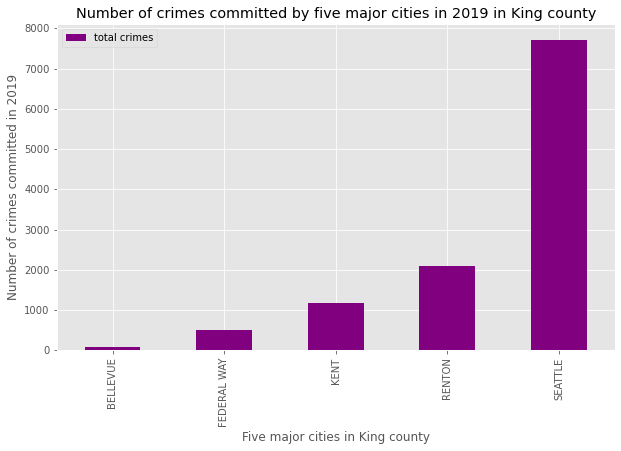

In [10]:
crime_count_major_cities = crime_count[(crime_count['city'] == 'SEATTLE') | (crime_count['city'] == 'BELLEVUE') | 
                   (crime_count['city'] == 'KENT') | (crime_count['city'] == 'RENTON')|
                   (crime_count['city'] == 'FEDERAL WAY')]
crime_count_major_cities = crime_count_major_cities[['city','incident_type']]
crime_count_major_cities.rename(columns={'incident_type':'total crimes'}, inplace = True)
crime_count_major_cities.set_index('city', inplace = True)

mpl.style.use('ggplot')
crime_count_major_cities.plot(kind='bar', figsize=(10, 6), color = 'purple')
plt.xlabel('Five major cities in King county') # add to x-label to the plot
plt.ylabel('Number of crimes committed in 2019') # add y-label to the plot
plt.title('Number of crimes committed by five major cities in 2019 in King county') # add title to the plot

    
plt.show()

In [11]:
print('The total crimes reported in 2019 in Bellevue area are {} cases in total of {} cases around the County'.
      format(crime_count_major_cities['total crimes'][0], crime_df.shape[0]))

The total crimes reported in 2019 in Bellevue area are 72 cases in total of 20128 cases around the County


As we can see from the graph, **Bellevue** is the safest city with the least crime counts reported in 2019. Even though **Seattle** is the most popular and biggest city of King County, with almost 8000 cases committed in 2019, it is not a very safe city to consider buying properties or to live a peaceful life. </br>
Now that we have chosen **Bellevue** as our city of interest, let's dive deeper into it and explore its house prices in the past.
### 3.2 House prices analysis

In [12]:
#Let's read in our zipcode data
zipcode_df = pd.read_csv('All_Zipcodes_and_PO_Box_as_Centroids_for_King_County___zipcode_all_point.csv')
zipcode_df.head()

,X,Y,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,PREFERRED_CITY,FEATURE_SOURCE
0,-122.584242,47.855762,1,98364,98364,35.0,PO Box,PORT GAMBLE,Placed Point
1,-122.202454,47.620601,2,98009,98009,33.0,PO Box,BELLEVUE,Placed Point
2,-122.186795,47.611861,3,98015,98015,33.0,PO Box,BELLEVUE,Placed Point
3,-121.972726,47.419935,4,98025,98025,33.0,PO Box,HOBART,Placed Point
4,-122.234416,47.380592,5,98035,98035,33.0,PO Box,KENT,Placed Point


In [13]:
#Let's create a df named 'bv_df' that only has Bellevue's zipcodes and its latitude,longitude.
bv_df = zipcode_df[zipcode_df['PREFERRED_CITY'] == 'BELLEVUE'].reset_index()
bv_df = bv_df[['ZIPCODE','Y','X']]
bv_df.rename(columns={'ZIPCODE':'zipcode','Y':'latitude','X':'longitude'}, inplace = True)
bv_df

,zipcode,latitude,longitude
0,98009,47.620601,-122.202454
1,98015,47.611861,-122.186795
2,98004,47.619114,-122.203214
3,98005,47.616826,-122.167536
4,98006,47.560613,-122.147775
5,98007,47.617309,-122.143779
6,98008,47.607556,-122.117310


In [14]:
#Now let's read in house price dataset from Kaggle
house_df = pd.read_csv('kc_house_data.csv')
house_df = house_df[((house_df['zipcode'] >= 98004) & (house_df['zipcode'] <= 98009)) | (house_df['zipcode'] == 98015)].reset_index()
#house_df = house_df[['zipcode','price','lat','long']]

print(house_df.shape)
print(house_df['zipcode'].unique())
house_df.head()

(1407, 22)
[98007 98008 98004 98005 98006]


,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10,1736800520,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
1,47,4178300310,20140716T000000,785000.0,4,2.50,2290,13416,2.0,0,0,4,9,2290,0,1981,0,98007,47.6194,-122.151,2680,13685
2,58,7922800400,20140827T000000,951000.0,5,3.25,3250,14342,2.0,0,4,4,8,3250,0,1968,0,98008,47.5880,-122.116,2960,11044
3,66,3394100030,20140909T000000,975000.0,4,2.50,2720,11049,2.0,0,0,3,10,2720,0,1989,0,98004,47.5815,-122.192,2750,11049
4,69,1802000060,20140612T000000,1325000.0,5,2.25,3200,20158,1.0,0,0,3,8,1600,1600,1965,0,98004,47.6303,-122.215,3390,20158


We are not going to dig too deep into this dataset about house prices, but let's see the basic correlation between the house price dataset's features.

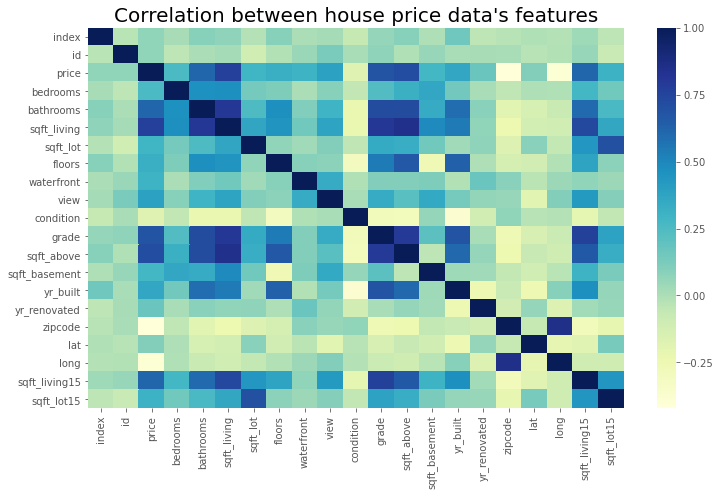

In [15]:
def corr_heatmap(data):
    ax = plt.subplots(figsize = (12, 7))
    sns.heatmap(house_df.corr(), cmap="YlGnBu")
    plt.title("Correlation between house price data's features", fontsize = 20)
corr_heatmap(house_df.corr())  

Even though the dataset about house prices look very interesting, we are not going to analyze the price as a whole, but rather compare the average house prices by **Bellevue**'s zipcodes. Throughout this project, I will use *zipcode* as an indicator of the neighborhood since I do not have much data on the neighborhoods themselves and the maps (will be created later) will tell pretty much everything we need to know about **Bellevue**.

In [16]:
#Create temp df to sort values and calculate the price_mean()
temp = house_df.groupby('zipcode').mean().reset_index()
temp = temp.sort_values('price' , ascending = False)
#Convert zipcode to 'string' for the plot
temp['zipcode'] = list(map(str, temp['zipcode']))
house_plot = temp[['zipcode','price']]
house_plot.set_index('zipcode' ,inplace = True)
house_plot

,price
zipcode,
98004,1.355927e+06
98006,8.596848e+05
98005,8.101649e+05
98008,6.455074e+05
98007,6.171051e+05


At a quick glance, every neighborhood of the city of Bellevue has a relatively high on the house price average. Specifically, in average, houses in 98004 neighborhood cost about **1.4 million US dollars** and they all seem to set a very high standards for houses in this city. So, my recommendation for buying a house around this city is to have a budget with at least $600k. </br>
Let's visually see those figures in a bar graph.

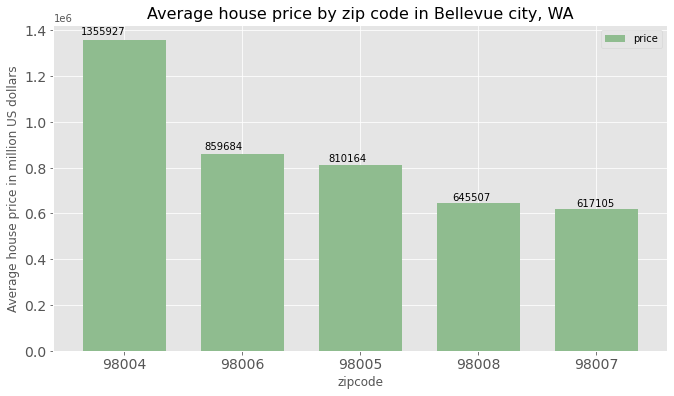

In [17]:
# Create the plot
ax = house_plot.plot(kind='bar',
                       figsize = (11,6),
                       width = 0.7,
                       color = ['#8FBC8F'],
                       fontsize = 14                   
                       )

# Add title
plt.xticks(rotation = 0)
plt.title('Average house price by zip code in Bellevue city, WA', fontsize=16)
plt.ylabel('Average house price in million US dollars')

for x in ax.patches:
    ax.annotate(str(x.get_height().astype(int)) , (x.get_x() * 1.05, x.get_height() * 1.02))

plt.show()

### 3.3 Explore the neighborhood

- Use geopy library to get the latitude and longitude values of Bellevue City.
- Then we define a user_agent, namely bv_explorer, to define an instance of the geocoder.

In [18]:
# Nominatim is used to convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="bv_explorer")
location = geolocator.geocode('Bellevue, WA')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bellevue City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bellevue City are 47.6144219, -122.1923372.


I then use Python **folium** library to visualize the map of Bellevue city with its neighborhoods circled below.

In [19]:
# create map of Bellevue using latitude and longitude values
map_bv = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, zipcode in zip(bv_df['latitude'], bv_df['longitude'], bv_df['zipcode'],):
    label = '{}'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=12,
        popup=label,
        color='green',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bv)  
    
map_bv

I then use **Foursquare API** to explore the neighborhoods to get to know more about the city itself.

In [20]:
CLIENT_ID = 'VP20C5A3F11IKFP113UKD034OSLD1352NCLAISJYYE0UKKAE' 
CLIENT_SECRET = '2ANW2CSUTTLD1J04FNQIHSKW2A3RYOBY4O0IYD1DPMM0NDCH' 
ACCESS_TOKEN = 'TLW3H3WI2LGI25ENBZG3QG1ASOC4WCPJJBC5XRJYB5PNRQQB'

VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('ACCESS TOKEN :' + ACCESS_TOKEN)

Your credentails:
CLIENT_ID: VP20C5A3F11IKFP113UKD034OSLD1352NCLAISJYYE0UKKAE
CLIENT_SECRET:2ANW2CSUTTLD1J04FNQIHSKW2A3RYOBY4O0IYD1DPMM0NDCH
ACCESS TOKEN :TLW3H3WI2LGI25ENBZG3QG1ASOC4WCPJJBC5XRJYB5PNRQQB


As mentioned above, the **98004** neighborhood seems to be the most expensive neighborhood, let's explore it and see why its property value is that expensive compared to other neighborhoods.

In [21]:
#Get the lat and long of 98004 neighborhood from the data above
neighborhood_latitude = bv_df.loc[2, 'latitude'] # neighborhood latitude value
neighborhood_longitude = bv_df.loc[2, 'longitude'] # neighborhood longitude value
neighborhood_zipcode = bv_df.loc[2, 'zipcode'] # neighborhood zipcode

print('Latitude and longitude values of {} neighborhood are {}, {}.'.format(neighborhood_zipcode, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 98004 neighborhood are 47.6191142555335, -122.20321399965201.


I then set the limit of 100 venues around the neighborhood and the radius of 500m to see the most common venues around this neighborhood. I create URL using 'explore' endpoint and 'get' method to get the results.

In [22]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

 # create URL using explore 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head(10)


100 venues were returned by Foursquare.


,name,categories,lat,lng
0,Facing East,Taiwanese Restaurant,47.619793,-122.202635
1,Hyatt Regency Bellevue On Seattle's Eastside,Hotel,47.618813,-122.200431
2,Nordstrom,Women's Store,47.616981,-122.204021
3,Obadiah Salon,Salon / Barbershop,47.617721,-122.200467
4,Black Bottle Postern,Gastropub,47.618614,-122.201831
5,Din Tai Fung Dumpling House,Dumpling Restaurant,47.617241,-122.200793
6,Ruth's Chris Steak House,Steakhouse,47.617222,-122.202934
7,Daniel's Broiler,Steakhouse,47.617836,-122.200343
8,Crate & Barrel,Furniture / Home Store,47.617123,-122.202100
9,Yuan Spa,Spa,47.619426,-122.199164


In [24]:
print('There are {} uniques categories around this neighborhood.'.format(len(nearby_venues['categories'].unique())))
freq_98004_venues = nearby_venues.groupby('categories').count().reset_index()
freq_98004_venues = freq_98004_venues.sort_values('name', ascending = False)
freq_98004_venues = freq_98004_venues[['categories', 'name']]
freq_98004_venues.rename(columns={'name':'frequencies'},inplace = True)
freq_98004_venues.head(10)

There are 66 uniques categories around this neighborhood.


,categories,frequencies
18,Coffee Shop,5
64,Women's Store,4
30,Hotel,4
16,Clothing Store,3
45,Pizza Place,3
25,Furniture / Home Store,3
49,Seafood Restaurant,3
51,Shopping Mall,3
11,Café,3
52,Spa,3


> Observation: This is a small neighborhood with mostly coffee shop, hotel, stores, mall, and restaurants, etc. saying that this is most likely the city center area, which is for offices, tourists, bussinesses, and large companies. </br>
Let's visualize this data using **bar chart** and **WordCloud**

Text(0, 0.5, 'Number of venues')

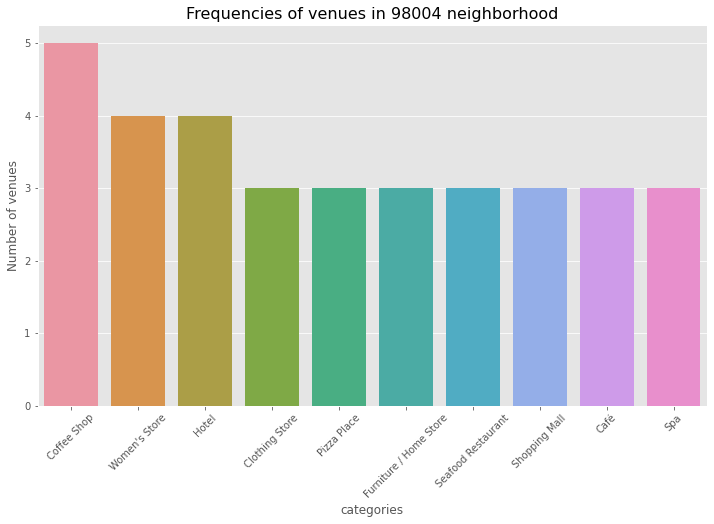

In [25]:
# Create the plot
temp = freq_98004_venues.head(10)
plt.figure(figsize=(12,7))
sns.barplot(x = "categories", y = "frequencies", data = temp);

# Add title
plt.xticks(rotation = 45)
plt.title('Frequencies of venues in 98004 neighborhood', fontsize=16)
plt.ylabel('Number of venues')


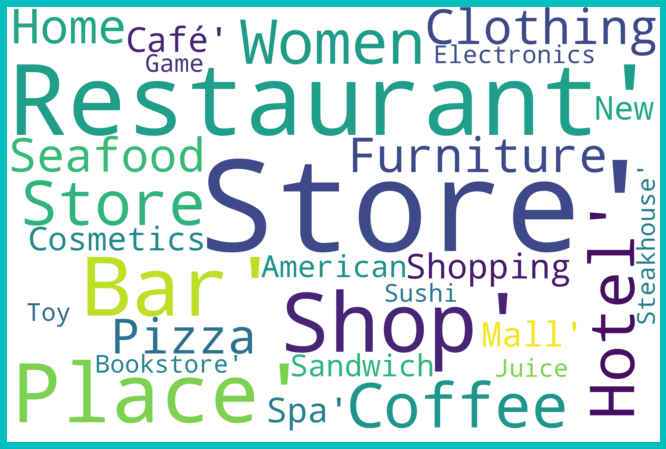

In [26]:
#Create the cloud
text = freq_98004_venues['categories'].head(20).values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (14, 8),
    facecolor = 'c',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=1300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(venues_list)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood zipcode',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
bellevue_venues = getNearbyVenues(names=bv_df['zipcode'],
                                   latitudes=bv_df['latitude'],
                                   longitudes=bv_df['longitude']
                                  )

In [ ]:
print(bellevue_venues.shape)
print('There are {} uniques categories.'.format(len(bellevue_venues['Venue Category'].unique())))
bellevue_venues.head(15)

In [ ]:
# one hot encoding
bellevue_onehot = pd.get_dummies(bellevue_venues[['Venue Category']], prefix="", prefix_sep="")

#Drop the column Neighborhood and then insert it again to the first column
#bellevue_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
bellevue_onehot.insert(loc=0, column='Neighborhood', value=bellevue_venues['Neighborhood zipcode'] )

print(bellevue_onehot.shape)
bellevue_onehot.head()

In [ ]:
bellevue_grouped = bellevue_onehot.groupby('Neighborhood').mean().reset_index()
print(bellevue_grouped.shape)
bellevue_grouped

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bellevue_grouped['Neighborhood']

for ind in np.arange(bellevue_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bellevue_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

### 3.4 Cluster the neighborhoods

In [ ]:
# set number of clusters
kclusters = 3

bellevue_grouped_clustering = bellevue_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bellevue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bellevue_merged = bv_df[['zipcode','latitude','longitude']]
bellevue_merged.rename(columns={'zipcode':'Neighborhood'},inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bellevue_merged = bellevue_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bellevue_merged


In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bellevue_merged['latitude'], bellevue_merged['longitude'], bellevue_merged['Neighborhood'], bellevue_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
crime_count_bv = crime_df[crime_df['city'] == 'BELLEVUE']
crime_count_bv = crime_count_bv.groupby('zipcode').size().reset_index()
crime_count_bv.rename(columns={0:'counts'},inplace = True)

columns_names = ['Clusters','Counts']
crime_count_bv_cl = pd.DataFrame([['Cluster 0',crime_count_bv.iloc[4][1]], ['Cluster 1',crime_count_bv.iloc[0][1]
                                                                           +crime_count_bv.iloc[1][1]
                                                                           +crime_count_bv.iloc[3][1]], ['Cluster 2',crime_count_bv.iloc[2][1]]],columns = columns_names)
crime_count_bv_cl.sort_values('Counts', ascending = True, inplace = True)
crime_count_bv_cl.set_index('Clusters', inplace = True)
crime_count_bv_cl


In [ ]:
# Create the plot
ax = crime_count_bv_cl.plot(kind='bar',
                       figsize = (10,6),
                       width = 0.7,
                       color = ['red'],
                       fontsize = 14                   
                       )

# Add title

plt.xticks(rotation = 0)
plt.title('Crime counts by Clusters in Bellevue', fontsize=16)
plt.ylabel('Number of crimes reported')
plt.rcParams["axes.grid"] = False

for x in ax.patches:
    ax.annotate(str(x.get_height()) + ' cases' , (x.get_x() * 1, x.get_height() * 1.0))

plt.show()


# 4.Results

In [ ]:
#Examine cluster 2 - 98006
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1200 # define radius

neighborhood_laitude = 47.560613
neighborhood_longitude = -122.147775

 # create URL using explore 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('{} venues were returned by Foursquare around cluster 2.'.format(nearby_venues.shape[0]))
print('There are {} uniques categories around this neighborhood.'.format(len(nearby_venues['categories'].unique())))
freq_98006_venues = nearby_venues.groupby('categories').count().reset_index()
freq_98006_venues = freq_98006_venues.sort_values('name', ascending = False)
freq_98006_venues = freq_98006_venues.drop(['lat','lng'],axis = 1)
text = freq_98006_venues['categories'].head(20)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (14, 8),
    facecolor = 'c',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**CLUSTER 2:** Residential neighborhood by the Lake.

In [ ]:
#Examine cluster 0 - 98008
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

neighborhood_laitude = 47.607556
neighborhood_longitude = -122.117310

 # create URL using explore 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('{} venues were returned by Foursquare around cluster 0.'.format(nearby_venues.shape[0]))
print('There are {} uniques categories around this neighborhood.'.format(len(nearby_venues['categories'].unique())))
freq_98008_venues = nearby_venues.groupby('categories').count().reset_index()
freq_98008_venues = freq_98008_venues.sort_values('name', ascending = False)
freq_98008_venues = freq_98008_venues.drop(['lat','lng'],axis = 1)
text = freq_98008_venues['categories'].head(20)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (14, 8),
    facecolor = 'c',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**CLUSTER 0:** Residential neighborhood by Parks and Playgrounds

In [ ]:
#Examine cluster 1

bv_df_c1 = bv_df[(bv_df['zipcode'] != 98006) & (bv_df['zipcode'] != 98008)]

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1200 # define radius

neighborhood_latitude = bv_df_c1['latitude'].mean()
neighborhood_longitude = bv_df_c1['longitude'].mean()

 # create URL using explore 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('{} venues were returned by Foursquare around cluster 1.'.format(nearby_venues.shape[0]))
print('There are {} uniques categories around this neighborhood.'.format(len(nearby_venues['categories'].unique())))
freq_98006_venues = nearby_venues.groupby('categories').count().reset_index()
freq_98006_venues = freq_98006_venues.sort_values('name', ascending = False)
freq_98006_venues = freq_98006_venues.drop(['lat','lng'],axis = 1)
text = freq_98006_venues['categories'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (14, 8),
    facecolor = 'c',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**CLUSTER 1**: City Center and Bussinesses Venues

# 5.Discussion
First of all, King County is one of the best place to live in the US right now. I used public dataset of King County Sheriff's crimes reported in 2019 to conclude that among five major cities of King County, **Bellevue** is the safest city to consider buying properties and settling down with comparatively low crime cases reported in 2019. </br> </br>
I have noticed that house prices distribution around this city is relatively high, which sets a unique standards for individuals who want to move in this city's neighborhood. **98004** neighborhood is the most expensive neighborhood which has averagely 1.4 million US dollars for a house. For more in depth of King County's house prices analysis and prediction, please visit [HERE](https://github.com/luongtruong7793/House-Sales-in-King-County-WA/blob/master/House%20Sales%20in%20King%20County%2C%20USA.ipynb) </br></br>
I also used **Folium** to create maps around **Bellevue** and utilized **Foursquare API** to segment and cluster neighborhoods of **Bellevue** into 3 clusters, each of cluster has its own characteristics. Furthermore, I used **WordCloud** to visualize the frequencies of venues around 3 clusters to emphasize their aspects. </br></br>
I've then deduced 3 clusters of **Belevue** into:
- **CLUSTER 0: Residential neighborhood by Parks and Playgrounds**
- **CLUSTER 1: City Center and Bussinesses Venues**
- **CLUSTER 2: Residential neighborhood by the Lake**

# 6.Conclusion
Based on what we have learned about **Bellevue** city, I would recommend stakeholders and customers (in this case a family of four with upper-middle class income) to consider neighborhood around **CLUSTER 0 (zipcode 98008)** since it has the lowest crime rate, house prices around 600k-700k US dollars, there are parks and playgrounds for kids, etc. </br> </br>
There is no doubt that **Bellevue** never stops growing since there are many top companies located here (Microsoft, Amazon, T-Mobile, Boeing, etc.) and it is also very close the famous University of Washington. As a data scientist, I have found that **Bellevue** is considered one of the best places for jobs, schools, communities, entertainments, etc.